In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../ragali/')

import get_datasets

# Download and transform OpenMRG

In [3]:
#get_datasets.download_andersson_2022_OpenMRG()

In [4]:
ds_openmrg = get_datasets.transform_andersson_2022_OpenMRG(
    'OpenMRG.zip',
    'data/andersson_2022_OpenMRG',
    time_start_end=('2015-07-27T00', '2015-07-28T06'),
    restructure_data=True,
)

/Users/chwala-c/code/ragali/notebooks/dev_notebooks/../../ragali/get_datasets.py:309: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'sublink' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  ds_multindex = ds.assign_coords({'sublink': df_metadata.index})


In [5]:
ds_openmrg

<xarray.Dataset>
Dimensions:       (sublink_id: 2, cml_id: 364, time: 11160)
Coordinates:
  * sublink_id    (sublink_id) <U9 'sublink_1' 'sublink_2'
  * cml_id        (cml_id) int64 10001 10002 10003 10004 ... 10362 10363 10364
  * time          (time) datetime64[ns] 2015-07-27 ... 2015-07-28T06:59:50
    site_0_lat    (cml_id) float64 57.7 57.73 57.69 57.71 ... 57.65 57.66 57.71
    site_0_lon    (cml_id) float64 12.0 11.98 11.97 11.97 ... 12.12 12.03 12.01
    site_1_lat    (cml_id) float64 57.7 57.72 57.69 57.7 ... 57.66 57.63 57.71
    site_1_lon    (cml_id) float64 11.99 11.97 11.98 11.97 ... 12.14 11.97 11.98
    frequency     (sublink_id, cml_id) float64 2.821e+04 3.853e+04 ... 2.926e+04
    polarization  (sublink_id, cml_id) <U1 'v' 'v' 'v' 'v' ... 'v' 'v' 'v' 'v'
    length        (cml_id) float64 691.4 614.6 323.7 ... 4.806e+03 1.412e+03
Data variables:
    tsl           (time, sublink_id, cml_id) float32 1.0 0.0 -5.0 ... 16.0 0.0
    rsl           (time, sublink_id, cml_id) float32 -46.0 -41.3 ... -40.1 -50.4
Attributes: (12/14)
    title:                 OpenMRG-CML
    version:               1.1
    source:                Swedish Meteorological and Hydrological Institute ...
    contact:               hydro.fou@smhi.se, jafet.andersson@smhi.se
    license:               https://creativecommons.org/licenses/by-sa/4.0
    doi:                   https://doi.org/10.5281/zenodo.6673750
    ...                    ...
    institution:           NA
    date:                  NA
    history:               NA
    naming convention:     NA
    license restrictions:  NA
    reference:             NA

# Dev of format checker

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv(
    'https://raw.githubusercontent.com/OpenSenseAction/OS_data_format_conventions/main/netCDF_CML.adoc',
    sep='|',
    skiprows=9,    
)

df = df.drop(columns='Unnamed: 0').drop(0).set_index('Unnamed: 1')
df.index.name = 'Dimensions'

In [8]:
df_required = df[(df.Requisite == ' Required') | (df.Requisite == ' Required*')]
df_required

,Type,Attributes,Requisite,Comments
Dimensions,,,,
time (time),int/float/double,"units = ""seconds since 1970-01-01 00:00:00 UT...",Required,
cml_id (cml_id),string,long_name = “commercial_microwave_link_identi...,Required,cml_id has to be unique across the network
sublink_id (sublink_id),string,long_name = “sublink_identifier”,Required,sublink_id does not have to be unique across ...
site_0_lat (cml_id),float/double,"units = degrees_in_WGS84_projection, long_nam...",Required,
site_0_lon (cml_id),float/double,"units = degrees_in_WGS84_projection, long_nam...",Required,
site_1_lat (cml_id),float/double,"units = degrees_in_WGS84_projection, long_nam...",Required,
site_1_lon (cml_id),float/double,"units = degrees_in_WGS84_projection, long_nam...",Required,
"frequency (cml_id, sublink_id)",float/double,"units = MHz, long_name = “sublink_frequency”",Required,
"tsl (cml_id, sublink_id, time)",float/double,"units = dBm, coordinates = string_with_auxili...",Required*,


In [9]:
for row in df_required.iterrows():
    row


In [10]:
import re
split = re.split(r'\(|\)', row[0])
var_name, dims = split[0], split[1].split(',')
var_name, dims

(' rsl ', ['cml_id', ' sublink_id', ' time'])

In [11]:
OKGREEN = '\033[92m'
WARNING = '\033[93m'
FAIL = '\033[91m'
ENDC = '\033[0m'

ds = ds_openmrg


error_count = 0

print('Checking required variables...')
for row in df_required.iterrows():
    split = re.split(r'\(|\)', row[0])
    var_name, dims = split[0].strip(), tuple(split[1].split(','))
    print(f' {var_name}')
    try:
        ds[var_name]
        if ds[var_name].dims != dims:
            print(f"  {FAIL}dims of variable '{var_name}' are {ds[var_name].dims} but have to be {dims}{ENDC}")
            error_count += 1
        else:
            print(f"  {OKGREEN}OK{ENDC}")
    except:
        print(f"  {FAIL}Required variable '{var_name}' is missing{ENDC}")
        error_count += 1

print()
print(f"{FAIL}{error_count} errors found{ENDC}")



Checking required variables...
 time
  OK
 cml_id
  OK
 sublink_id
  OK
 site_0_lat
  OK
 site_0_lon
  OK
 site_1_lat
  OK
 site_1_lon
  OK
 frequency
  dims of variable 'frequency' are ('sublink_id', 'cml_id') but have to be ('cml_id', ' sublink_id')
 tsl
  dims of variable 'tsl' are ('time', 'sublink_id', 'cml_id') but have to be ('cml_id', ' sublink_id', ' time')
 rsl
  dims of variable 'rsl' are ('time', 'sublink_id', 'cml_id') but have to be ('cml_id', ' sublink_id', ' time')

3 errors found


In [12]:
import format_check

In [13]:
format_check.check_required_cml_metadata(ds_openmrg)

Checking required variables...
 time
  OK
 cml_id
  OK
 sublink_id
  OK
 site_0_lat
  OK
 site_0_lon
  OK
 site_1_lat
  OK
 site_1_lon
  OK
 frequency
  dims of variable 'frequency' are ('sublink_id', 'cml_id') but have to be ('cml_id', ' sublink_id')
 tsl
  dims of variable 'tsl' are ('time', 'sublink_id', 'cml_id') but have to be ('cml_id', ' sublink_id', ' time')
 rsl
  dims of variable 'rsl' are ('time', 'sublink_id', 'cml_id') but have to be ('cml_id', ' sublink_id', ' time')

3 errors found


In [3]:
import xarray as xr
ds_openmrg_cml = xr.open_dataset('../data/openMRG_example.nc')

In [4]:
import format_check
format_check.check_required_cml_metadata(ds_openmrg_cml)

Checking required variables...
 time
  OK
 cml_id
  OK
 sublink_id
  OK
 site_0_lat
  OK
 site_0_lon
  OK
 site_1_lat
  OK
 site_1_lon
  OK
 frequency
  dims of variable 'frequency' are ('sublink_id', 'cml_id') but have to be ('cml_id', ' sublink_id')
 tsl
  dims of variable 'tsl' are ('time', 'sublink_id', 'cml_id') but have to be ('cml_id', ' sublink_id', ' time')
 rsl
  dims of variable 'rsl' are ('time', 'sublink_id', 'cml_id') but have to be ('cml_id', ' sublink_id', ' time')

3 errors found


# Dev of `plot_ts`

In [5]:
import plot_ts

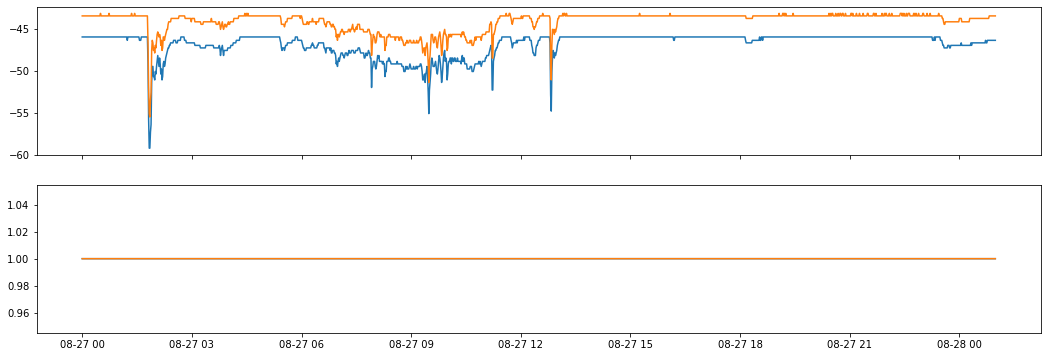

In [6]:
plot_ts.plot_cml_ts(ds_openmrg_cml.isel(cml_id=0), vars_to_plot=['rsl', 'tsl'])

# Dev of `plot_map`

In [4]:
import plot_map

In [6]:
import xarray as xr
ds_openmrg_cml = xr.open_dataset('../data/openMRG_example.nc')

In [8]:
%matplotlib widget

interactive(children=(SelectionSlider(description='t', options=(numpy.datetime64('2015-08-27T00:00:00.00000000…

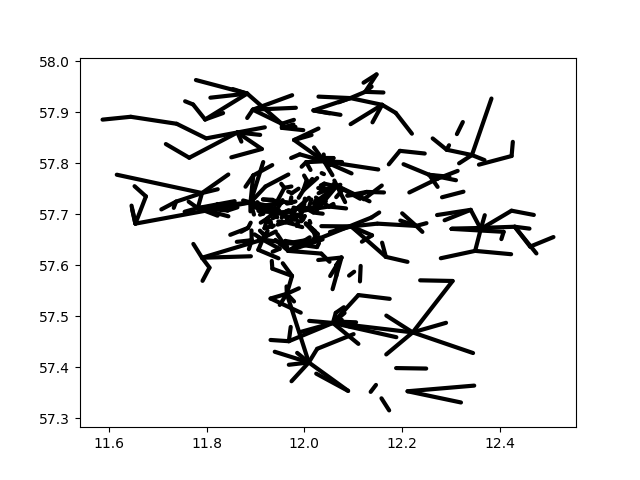

In [9]:
ds = ds_openmrg_cml

ds['trsl'] = ds.tsl - ds.rsl
ds['trsl'] = ds.trsl.interpolate_na(dim='time')
ds['A'] = ds.trsl - ds.trsl.rolling(time=600, center=True).median()

lines = plot_map.scatter_line(
    da=ds.isel(sublink_id=0).A,
    add_time_slider=True,
    vmin=0,
    vmax=30,
    linewidth=2,
    cmap='magma',
)

## Open smaller dataset for which there is also a small radar NetCDF

In [10]:
ds_cmls = xr.open_dataset('../data/openMRG_example.nc')
ds_cmls['trsl'] = ds_cmls.tsl - ds_cmls.rsl
ds_cmls['trsl'] = ds_cmls.trsl.interpolate_na(dim='time')
ds_cmls['A'] = ds_cmls.trsl - ds_cmls.trsl.rolling(time=60, center=True).median()

In [29]:
ds_radar = xr.open_dataset('../data/openMRG_example_rad.nc')
ds_radar

<xarray.Dataset>
Dimensions:   (time: 19, x: 37, y: 48)
Coordinates:
  * time      (time) datetime64[ns] 2015-08-27T01:00:00 ... 2015-08-27T02:30:00
  * x         (x) float64 -1.542e+05 -1.522e+05 ... -8.42e+04 -8.22e+04
  * y         (y) float64 -3.413e+06 -3.415e+06 ... -3.505e+06 -3.507e+06
Data variables:
    crs       int32 ...
    lat       (y, x) float32 ...
    lon       (y, x) float32 ...
    rainfall  (time, y, x) float64 ...
Attributes:
    source:       Swedish Meteorological and Hydrological Institute (SMHI), H...
    contact:      hydro.fou@smhi.se, remco.vandebeek@smhi.se
    title:        OpenMRG-Radar
    license:      https://creativecommons.org/licenses/by-sa/4.0
    version:      1.1
    doi:          https://doi.org/10.5281/zenodo.6673750
    proj_string:  +proj=stere +lat_ts=60 +ellps=bessel +lon_0=14 +lat_0=90
    comment:      Created by Remco van de Beek, Victor Näslund and Johan Thur...

In [79]:
import grid_intersection

intersect_weights = grid_intersection.calc_sparse_intersect_weights_for_several_cmls(
    ds_cmls=ds_openmrg_cml,
    x_grid=ds_radar.lon.T.values,
    y_grid=ds_radar.lat.T.values,
    #grid_point_location='lower_left',
    grid_point_location='center',
)

In [80]:
intersect_weights

Format,coo
Data Type,float64
Shape,"(364, 37, 48)"
nnz,386
Density,0.0005970943470943471
Read-only,True
Size,12.1K
Storage ratio,0.0


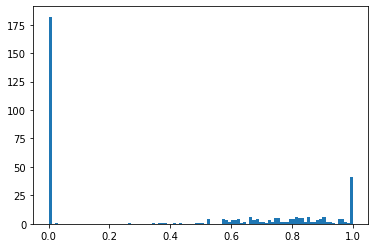

In [82]:
intersect_weights.sum(dim=['x', 'y']).plot.hist(bins=100);

In [83]:
%matplotlib inline

3719.42


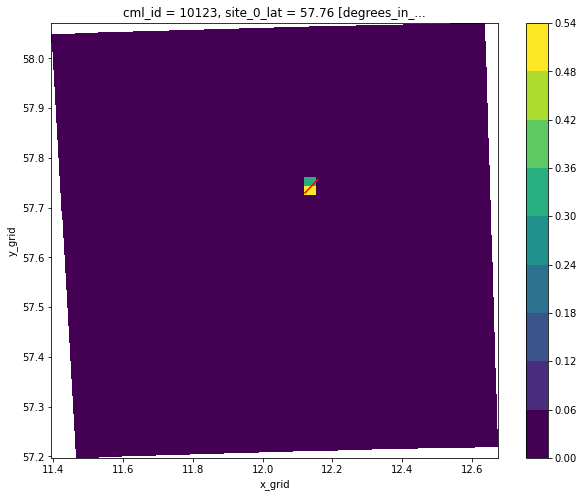

In [84]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))
i = 122

intersect_weights.isel(cml_id=i).plot(x='x_grid', y='y_grid', levels=10)
ds_i = ds_cmls.isel(cml_id=i)
ax.plot((ds_i.site_0_lon, ds_i.site_1_lon), (ds_i.site_0_lat, ds_i.site_1_lat), 'r')
print(ds_i.length.values)

In [85]:
import numpy as np
np.unique(intersect_weights.isel(cml_id=i).data.todense())

array([0.        , 0.31589609, 0.51823638])

In [223]:
intersec_weights.shape

(364, 37, 48)

In [224]:
ds_radar.lon.T.shape

(37, 48)

In [225]:
ds_radar.rainfall.transpose('time', 'x', 'y').shape

(19, 37, 48)

In [86]:
intersect_weights

Format,coo
Data Type,float64
Shape,"(364, 37, 48)"
nnz,386
Density,0.0005970943470943471
Read-only,True
Size,12.1K
Storage ratio,0.0


In [87]:
intersect_weights

Format,coo
Data Type,float64
Shape,"(364, 37, 48)"
nnz,386
Density,0.0005970943470943471
Read-only,True
Size,12.1K
Storage ratio,0.0


In [88]:
radar_along_cml = grid_intersection.get_grid_time_series_at_intersections(
    grid_data=ds_radar.rainfall.transpose('time', 'x', 'y').values,
    intersect_weights=intersect_weights,
)
radar_along_cml['time'] = ds_radar.time
radar_along_cml['site_0_lat'] = intersect_weights.site_0_lat
radar_along_cml['site_0_lon'] = intersect_weights.site_0_lon
radar_along_cml['site_1_lat'] = intersect_weights.site_1_lat
radar_along_cml['site_1_lon'] = intersect_weights.site_1_lon

In [89]:
%matplotlib inline

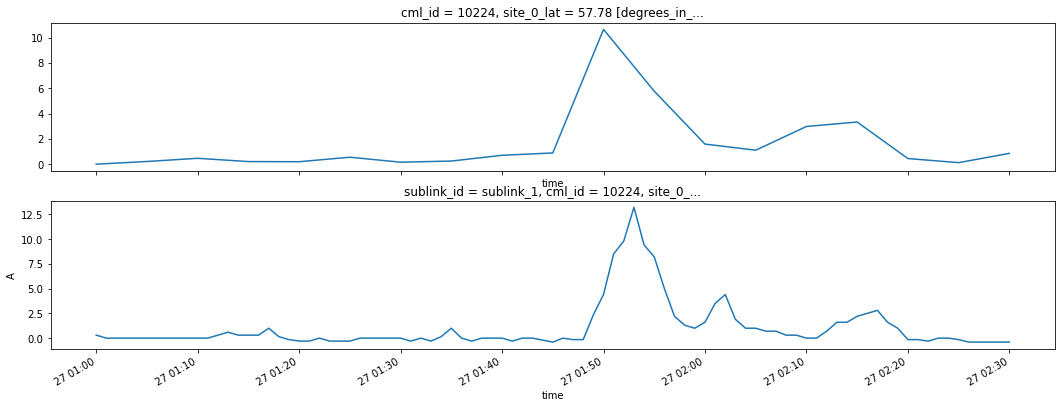

In [90]:
fig, axs = plt.subplots(2, 1, figsize=(18, 6), sharex=True)
i = 223
radar_along_cml.isel(cml_id=i).plot(ax=axs[0])
ds_cmls.isel(cml_id=i, sublink_id=0).sel(time=slice(radar_along_cml.time.min(), radar_along_cml.time.max())).A.plot(zorder=-3, ax=axs[1]);

In [91]:
%matplotlib widget

interactive(children=(SelectionSlider(description='t', options=(numpy.datetime64('2015-08-27T01:00:00.00000000…

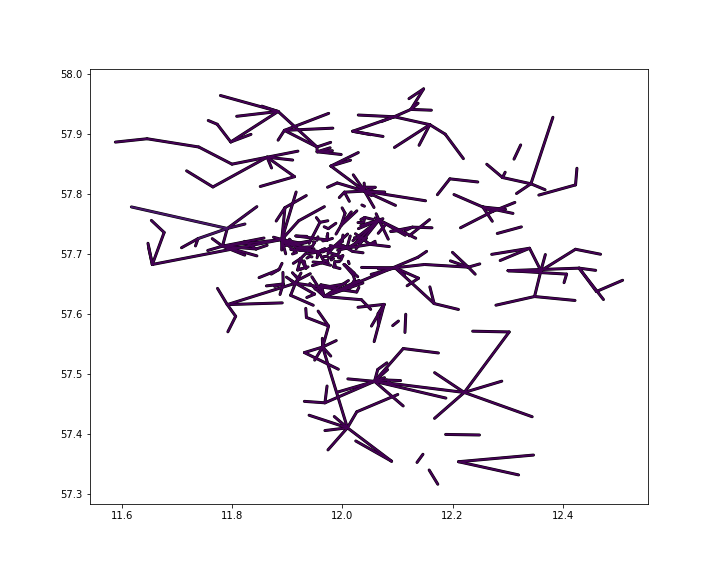

In [103]:
fig, ax = plt.subplots(figsize=(10, 8));
plot_map.scatter_line(
    da=radar_along_cml,
    add_time_slider=True,
    ax=ax,
    vmin=0,
    vmax=50,
);